<a href="https://colab.research.google.com/github/tomaszwk/NLP/blob/main/Desafio5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Bert Sentiment Analysis
[Ejemplo similar en Pytorch](https://colab.research.google.com/drive/1PHv-IRLPCtv7oTcIGbsgZHqrB5LPvB7S#scrollTo=m_mRflxPl32F)

In [1]:
!pip install transformers --quiet
import matplotlib.pyplot as plt

In [2]:
import tensorflow
from transformers import TFBertModel

### Definiendo modelo

In [4]:
bert_model = TFBertModel.from_pretrained("bert-base-uncased")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture

In [5]:
max_length = 140
output_shape = 3

In [85]:
bert_model.bert.trainable = False

input_ids = tensorflow.keras.layers.Input(shape=(max_length,), dtype=tensorflow.int32, name='input_ids')
attention_mask = tensorflow.keras.layers.Input(shape=(max_length,), dtype=tensorflow.int32, name='attention_mask')

outputs = bert_model(input_ids, attention_mask=attention_mask)

pooled_output = outputs.pooler_output

x = tensorflow.keras.layers.Dropout(0.2)(pooled_output)
output = tensorflow.keras.layers.Dense(output_shape, activation='softmax')(x)

model = tensorflow.keras.Model(inputs=[input_ids, attention_mask], outputs=output)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy',tensorflow.keras.metrics.F1Score(average='macro')])

ValueError: Exception encountered when calling layer 'tf_bert_model_7' (type TFBertModel).

Data of type <class 'keras.src.backend.common.keras_tensor.KerasTensor'> is not allowed only (<class 'tensorflow.python.framework.tensor.Tensor'>, <class 'bool'>, <class 'int'>, <class 'transformers.utils.generic.ModelOutput'>, <class 'tuple'>, <class 'list'>, <class 'dict'>, <class 'numpy.ndarray'>) is accepted for attention_mask.

Call arguments received by layer 'tf_bert_model_7' (type TFBertModel):
  • input_ids=<KerasTensor shape=(None, 140), dtype=int32, sparse=None, name=input_ids>
  • attention_mask=<KerasTensor shape=(None, 140), dtype=int32, sparse=None, name=attention_mask>
  • token_type_ids=None
  • position_ids=None
  • head_mask=None
  • inputs_embeds=None
  • encoder_hidden_states=None
  • encoder_attention_mask=None
  • past_key_values=None
  • use_cache=None
  • output_attentions=None
  • output_hidden_states=None
  • return_dict=None
  • training=False

In [18]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 140)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 140)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model_1 (TFBertMod  TFBaseModelOutputWithPooli   1094822   ['input_ids[0][0]',           
 el)                         ngAndCrossAttentions(last_   40         'attention_mask[0][0]']      
                             hidden_state=(None, 140, 7                                     

In [19]:
def plot_train_metrics(history):
    epoch_count = range(1, len(history.history['accuracy']) + 1)
    sns.lineplot(x=epoch_count,  y=history.history['accuracy'], label='train')
    sns.lineplot(x=epoch_count,  y=history.history['val_accuracy'], label='valid')
    plt.show()

### Datos
Utilizaremos como dataset críticas de Google Apps en formato csv.

In [ ]:
# Descargar la carpeta de dataset
!curl -L -o 'apps.csv' 'https://drive.google.com/u/0/uc?id=1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV&export=download&confirm=t'
!curl -L -o 'reviews.csv' 'https://drive.google.com/u/0/uc?id=1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv&export=download&confirm=t'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0


In [ ]:
import pandas as pd
# Armar el dataset
df = pd.read_csv('reviews.csv')
df.head()

In [ ]:
print("Cantidad de críticas:", len(df))

In [ ]:
import seaborn as sns
# ¿Cómo están balanceados los datos?
sns.countplot(x=df.score)

## Limpieza de datos

In [ ]:
# Balancear los datos
df['sentiment'] = df.score.apply(lambda x: 0 if x <=2 else 1 if x == 3 else 2)
class_names = ['negative', 'neutral', 'positive']

<ipython-input-31-15c40b0fa175>:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(class_names);


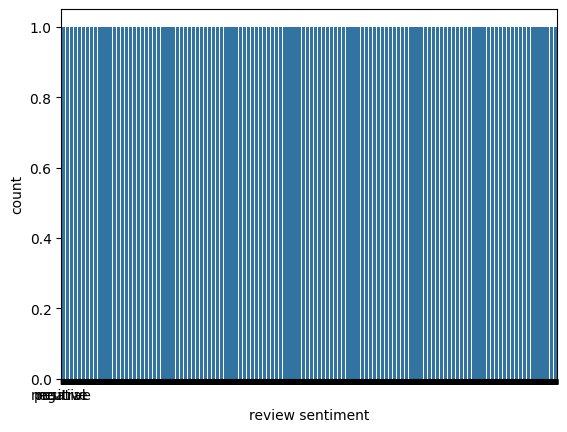

In [31]:
ax = sns.countplot(df.sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names);

In [32]:
sentences = df['content'].values
print("sentences shape:", sentences.shape)
sentences[:3]

sentences shape: (15746,)


array(["Update: After getting a response from the developer I would change my rating to 0 stars if possible. These guys hide behind confusing and opaque terms and refuse to budge at all. I'm so annoyed that my money has been lost to them! Really terrible customer experience. Original: Be very careful when signing up for a free trial of this app. If you happen to go over they automatically charge you for a full years subscription and refuse to refund. Terrible customer experience and the app is just OK.",
       'Used it for a fair amount of time without any problems. Suddenly then asked me to create an account or log using Google or FB. I used my Google one only to discover everything was gone!',
       "Your app sucks now!!!!! Used to be good but now doesn't update until I physically open it up and then close it then scroll and then it finally shows what I want to put on the list!!!!!! And I FRIGGEN paid for this garbage!!!!!!!"],
      dtype=object)

Median: 139.0


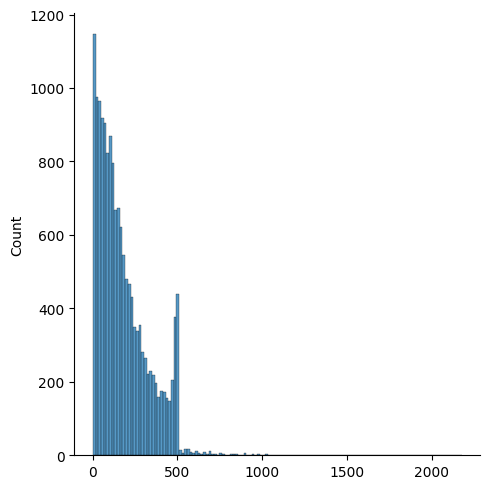

In [34]:
import numpy as np
sentence_lens = []

for sentence in sentences:
  sentence_lens.append(len(sentence))

print("Median:", np.median(sentence_lens))
sns.displot(sentence_lens)

In [35]:
from tensorflow.keras.utils import to_categorical

In [36]:
y = df['sentiment'].values
print("y shape:", y.shape)
y = to_categorical(y)
print(y[:3])
output_shape = y.shape[1]
print("output shape:", output_shape)

y shape: (15746,)
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]
output shape: 3


## 1 - Data generator


In [37]:
from transformers import InputExample, InputFeatures  # Métodos para transformar el dataset
from transformers import BertTokenizer
import numpy as np

In [38]:
# Muy importante que para tensorflow los modelos Bert deben empezar con "TF"
# de lo contrario estaremos utilizando un modelo para pytorch

# Descargamos el modelo base de BERT más liviano y su correspondiente tokenizer
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [39]:
# Del dataset original accederemos a los datos por índices (idx)
# mezclados aleatoriamente
from sklearn.model_selection import train_test_split
max_length = 140 # BERT soporta máximo 512
indices = np.arange(len(sentences))
idx_train_val, idx_test = train_test_split(indices, test_size=0.2, random_state=42)
idx_train, idx_val = train_test_split(idx_train_val, test_size=0.2, random_state=42)

In [40]:
print(idx_train.shape[0], idx_val.shape[0], idx_test.shape[0])

10076 2520 3150


In [41]:

def convert_data_to_examples(text, labels, idx_train, idx_val):
    # Armamos un "InputExample" para los datos de entrenamiento y validación
    train_InputExamples = [InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = text[i],
                                                          text_b = None,
                                                          label = labels[i]) for i in idx_train]

    validation_InputExamples = [InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = text[i],
                                                          text_b = None,
                                                          label = labels[i]) for i in idx_val]

    return train_InputExamples, validation_InputExamples


def convert_examples_to_tf_dataset(examples, bert_tokenizer, max_length=512):
    # Transformamos los datos de entrada en tensorres de:
    # input_ids --> token id
    # attention_mask
    # token type
    features = []

    for e in examples:
        # Documentation is really strong for this method, so please take a look at it
        input_dict = bert_tokenizer.encode_plus(
            e.text_a,
            add_special_tokens=True,
            max_length=max_length, # truncates if len(s) > max_length
            return_token_type_ids=False,
            return_attention_mask=True,
            padding='max_length', # pads to the right by default # CHECK THIS for pad_to_max_length
            truncation=True
        )

        input_ids, attention_mask = (input_dict["input_ids"], input_dict['attention_mask'])

        features.append(
            InputFeatures(
                input_ids=input_ids, attention_mask=attention_mask, label=e.label
            )
        )

    def gen():
    # Función generadora para no levantar todos los datos en un instante
        for f in features:
            yield (
                {
                    "input_ids": f.input_ids,
                    "attention_mask": f.attention_mask,
                },
                f.label,
            )

    return tensorflow.data.Dataset.from_generator(
        # Tensorflow dataset generator (basado en el generador y en el esquema de datos definido)
        gen,
        ({"input_ids": tensorflow.int32, "attention_mask": tensorflow.int32}, tensorflow.float32),
        (
            {
                "input_ids": tensorflow.TensorShape([None]),
                "attention_mask": tensorflow.TensorShape([None]),
            },
            tensorflow.TensorShape([output_shape]),
        ),
    )

In [42]:
train_InputExamples, validation_InputExamples = convert_data_to_examples(sentences, y, idx_train, idx_val)

train_data = convert_examples_to_tf_dataset(list(train_InputExamples), bert_tokenizer, max_length=max_length)
# shuffle 100 --> mezcla los datos y los lee a de 100 unidades
# batch 32 --> ejecuta una epoca de entrenamiento de a 32 unidades
train_data = train_data.shuffle(100).batch(32)

validation_data = convert_examples_to_tf_dataset(list(validation_InputExamples), bert_tokenizer, max_length=max_length)
validation_data = validation_data.batch(32)

In [43]:
pred_sentences = [sentences[i] for i in idx_test]
tf_batch = bert_tokenizer(pred_sentences, max_length=max_length, padding=True, truncation=True, return_tensors='tf')

In [44]:
X_test = [tf_batch['input_ids'],
          tf_batch['attention_mask']]

In [45]:
y_test = y[idx_test]

## 2 - BERT multiclass classification

In [48]:
history1 = model.fit(train_data, epochs=5, validation_data=validation_data)

Epoch 1/5
315/315 [==============================] - 151s 412ms/step - loss: 1.1180 - accuracy: 0.3891 - f1_score: 0.3826 - val_loss: 1.0301 - val_accuracy: 0.4853 - val_f1_score: 0.3890
Epoch 2/5
315/315 [==============================] - 143s 454ms/step - loss: 1.0362 - accuracy: 0.4658 - f1_score: 0.4578 - val_loss: 1.0004 - val_accuracy: 0.4758 - val_f1_score: 0.3977
Epoch 3/5
315/315 [==============================] - 126s 400ms/step - loss: 0.9896 - accuracy: 0.5080 - f1_score: 0.4980 - val_loss: 0.9389 - val_accuracy: 0.5536 - val_f1_score: 0.5006
Epoch 4/5
315/315 [==============================] - 126s 400ms/step - loss: 0.9744 - accuracy: 0.5140 - f1_score: 0.5046 - val_loss: 0.9268 - val_accuracy: 0.5440 - val_f1_score: 0.4925
Epoch 5/5
315/315 [==============================] - 126s 399ms/step - loss: 0.9588 - accuracy: 0.5255 - f1_score: 0.5158 - val_loss: 0.9008 - val_accuracy: 0.5766 - val_f1_score: 0.5685


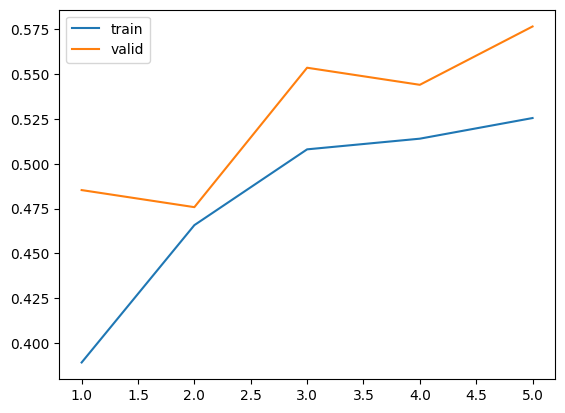

In [49]:
plot_train_metrics(history1)

In [50]:
y_hat_prob = model.predict(X_test)
y_hat_prob[:3]

99/99 [==============================] - 38s 306ms/step


array([[0.50329524, 0.3520598 , 0.14464496],
       [0.46227875, 0.28814468, 0.2495766 ],
       [0.2526134 , 0.3804663 , 0.36692026]], dtype=float32)

In [51]:
y_hat = np.argmax(y_hat_prob, axis=1)

In [52]:
# Calcular la exactitud (accuracy)
scores = model.evaluate(X_test, y_test)
scores[1]

99/99 [==============================] - 34s 310ms/step - loss: 0.9049 - accuracy: 0.5787 - f1_score: 0.5672


0.5787301659584045

ValueError: The number of FixedLocator locations (3), usually from a call to set_ticks, does not match the number of labels (10).

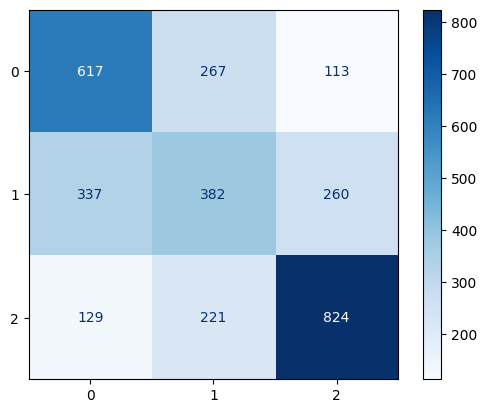

In [53]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test.argmax(axis=1), y_hat)
cmd = ConfusionMatrixDisplay(cm, display_labels=list(range(10)))
cmd.plot(cmap=plt.cm.Blues)
plt.show()

## 3 - BERT Fine tuning

In [59]:
model2 = model

# Colocar todas las layers como entrenables
for layer in model2.layers:
  layer.trainable = True

# Como es fine tunning se recomiendo utiliza al menos un learning rate 100 veces
# menor

import tensorflow as tf

model2.compile(optimizer=tf.optimizers.Adam(learning_rate=0.00001),
               loss='categorical_crossentropy',
               metrics=['accuracy'])
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 140)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 140)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model_1 (TFBertMod  TFBaseModelOutputWithPooli   1094822   ['input_ids[0][0]',           
 el)                         ngAndCrossAttentions(last_   40         'attention_mask[0][0]']      
                             hidden_state=(None, 140, 7                                     

In [60]:
history2 = model2.fit(train_data, epochs=5, validation_data=validation_data)

Epoch 1/5
315/315 [==============================] - 338s 937ms/step - loss: 0.7532 - accuracy: 0.6570 - val_loss: 0.6673 - val_accuracy: 0.7099
Epoch 2/5
315/315 [==============================] - 291s 925ms/step - loss: 0.6082 - accuracy: 0.7318 - val_loss: 0.6274 - val_accuracy: 0.7286
Epoch 3/5
315/315 [==============================] - 291s 924ms/step - loss: 0.4663 - accuracy: 0.8015 - val_loss: 0.6177 - val_accuracy: 0.7679
Epoch 4/5
315/315 [==============================] - 291s 924ms/step - loss: 0.3229 - accuracy: 0.8757 - val_loss: 0.6701 - val_accuracy: 0.8028
Epoch 5/5
315/315 [==============================] - 291s 923ms/step - loss: 0.2112 - accuracy: 0.9191 - val_loss: 0.7959 - val_accuracy: 0.8012


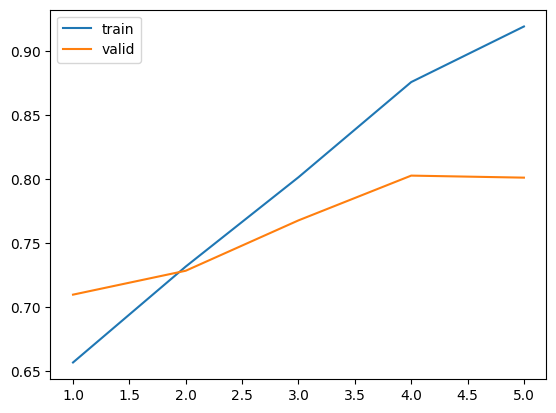

In [61]:
plot_train_metrics(history2)

In [62]:
y_hat_prob2 = model2.predict(X_test)
y_hat_prob2[:3]

99/99 [==============================] - 33s 302ms/step


array([[2.1263848e-01, 7.4083275e-01, 4.6528783e-02],
       [9.9765468e-01, 2.3410846e-03, 4.1207586e-06],
       [8.0735600e-03, 5.4349524e-01, 4.4843113e-01]], dtype=float32)

In [63]:
y_hat2 = np.argmax(y_hat_prob2, axis=1)

In [64]:
# Calcular la exactitud (accuracy)
scores = model2.evaluate(X_test, y_test)
scores[1]

99/99 [==============================] - 33s 303ms/step - loss: 0.7774 - accuracy: 0.8152


0.8152381181716919

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test.argmax(axis=1), y_hat2)
cmd = ConfusionMatrixDisplay(cm, display_labels=list(range(10)))
cmd.plot(cmap=plt.cm.Blues)
plt.show()

## Salvar el modelo

In [65]:
model2.save_weights('bert_weights.h5')

In [66]:
# Descargar los pesos a nuestra PC
# Solo es necesario si se desea repetir el uso de este modelo en el futuro
from google.colab import files
files.download('bert_weights.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Levantar el modelo

In [6]:
bert_model3 = TFBertModel.from_pretrained("bert-base-uncased")

input_ids = tensorflow.keras.layers.Input(shape=(max_length,), dtype=tensorflow.int32, name='input_ids')

# attention_mask - is a binary mask which tells BERT which tokens to attend and which not to attend.
# Encoder will add the 0 tokens to the some sequence which smaller than MAX_SEQUENCE_LENGTH,
# and attention_mask, in this case, tells BERT where is the token from the original data and where is 0 pad token:
attention_mask = tensorflow.keras.layers.Input((max_length,), dtype=tensorflow.int32, name='attention_mask')

# Get the pooled_output (embedding que representa toda la entrada)
output = bert_model3([input_ids, attention_mask])[1]

# We can also add dropout as regularization technique:
output = tensorflow.keras.layers.Dropout(rate=0.2)(output)

# Se puede agregar más capas Densas en el medio si se desea

# Provide number of classes to the final layer:
output = tensorflow.keras.layers.Dense(output_shape, activation='softmax')(output)

# Final model:
model3 = tensorflow.keras.models.Model(inputs=[input_ids, attention_mask], outputs=output)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [72]:
model2.load_weights('bert_weights.h5')

## Ensayo

In [73]:
text = "I love this app!"

#tf_batch = bert_tokenizer(text, max_length=max_length, padding=True, truncation=True, return_tensors='tf')

tf_batch = bert_tokenizer.encode_plus(
    text,
    add_special_tokens=True,
    max_length=max_length, # truncates if len(s) > max_length
    return_token_type_ids=False,
    return_attention_mask=True,
    pad_to_max_length=True, # pads to the right by default # CHECK THIS for pad_to_max_length
    truncation=True,
    return_tensors='tf'
)

print("Inputs ids:", tf_batch['input_ids'])
print("Attention mask:", tf_batch['attention_mask'])

Inputs ids: tf.Tensor(
[[  101  1045  2293  2023 10439   999   102     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0]], shape=(1, 140), dtype=int32)
Attention mask: tf.Tensor(
[[1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

In [74]:
X_ensayo = [tf_batch['input_ids'],
          tf_batch['attention_mask']]

In [76]:
y_prob_ensayo = model2.predict(X_ensayo)
y_prob = np.argmax(y_prob_ensayo, axis=1)
print("Clasificación:", class_names[int(y_prob)])

1/1 [==============================] - 0s 161ms/step
Clasificación: positive


<ipython-input-76-059de9f228ce>:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("Clasificación:", class_names[int(y_prob)])


## Conclusiones

Se puede apreciar que luego de realizar el fine tuning el modelo se ajusta mucho mejor al problema. Existen diferentes formas de llevar a cabo este proceso, es importante que el learning rate sea mucho menor.\
Existen optimizadores pensados para fine tuning que realizan el ajuste de learning rate adaptativo a medida que se va entrenando capas más profundas del modelo.

Entrenar un modelo de clasificación para el dataset propuesto (reviews de apps) utilizando BERT como encoder fijo (pesos freezados) y entrenando solamente la última parte de la red para clasificación. La elección de la arquitectura de la última parte queda a su criterio (pueden usar densas, recurrentes, convolucionales o lo que sea).
Encaren el problema con la reducción de 3 clases y el problema original con 5 clases. Muestren los resultados de desempeño en cada caso.


In [8]:
import tensorflow as tf
from transformers import TFBertModel

max_length = 128  # Ajusta según sea necesario
output_shape = 2  # Ajusta según la cantidad de clases

# Cargar el modelo BERT preentrenado
bert_model = TFBertModel.from_pretrained("bert-base-uncased")
bert_model.bert.trainable = False  # Congelar las capas de BERT

# Definir las entradas
input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name='input_ids')
attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name='attention_mask')

# Pasar las entradas al modelo BERT por separado
outputs = bert_model(input_ids=input_ids, attention_mask=attention_mask)

# Obtener la salida 'pooler_output'
pooled_output = outputs.pooler_output

# Agregar una capa LSTM y una capa densa al final
x = tf.keras.layers.LSTM(128, return_sequences=False)(tf.expand_dims(pooled_output, axis=1))
x = tf.keras.layers.Dropout(0.2)(x)
output = tf.keras.layers.Dense(output_shape, activation='softmax')(x)

# Crear el modelo
model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)

# Compilar el modelo
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', tf.keras.metrics.F1Score(average='macro')])

# Ahora puedes entrenar el modelo usando `model.fit`


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w